<a href="https://colab.research.google.com/github/pranaychowdary765/-WTI-Crude-Oil-/blob/main/Dataset_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| Model              |    RMSE |     MAE | MAPE   | Directional Acc.   | Notes                                            |
|--------------------|---------|---------|--------|--------------------|--------------------------------------------------|
| LSTM(128→64), L=60 | 15.8167 | 11.4426 | 18.36% | 54.44%             | ~116033 params; 80/20 split; scaler fit on train |
| Model             |    RMSE |    MAE | MAPE   | Directional Acc.   | Notes                                           |
|-------------------|---------|--------|--------|--------------------|-------------------------------------------------|
| GRU(128→64), L=60 | 10.2278 | 7.7021 | 13.35% | 52.22%             | ~87617 params; 80/20 split; scaler fit on train |
| Model              |   RMSE |    MAE | MAPE   | Directional Acc.   | Notes                                                                 |
|--------------------|--------|--------|--------|--------------------|----------------------------------------------------

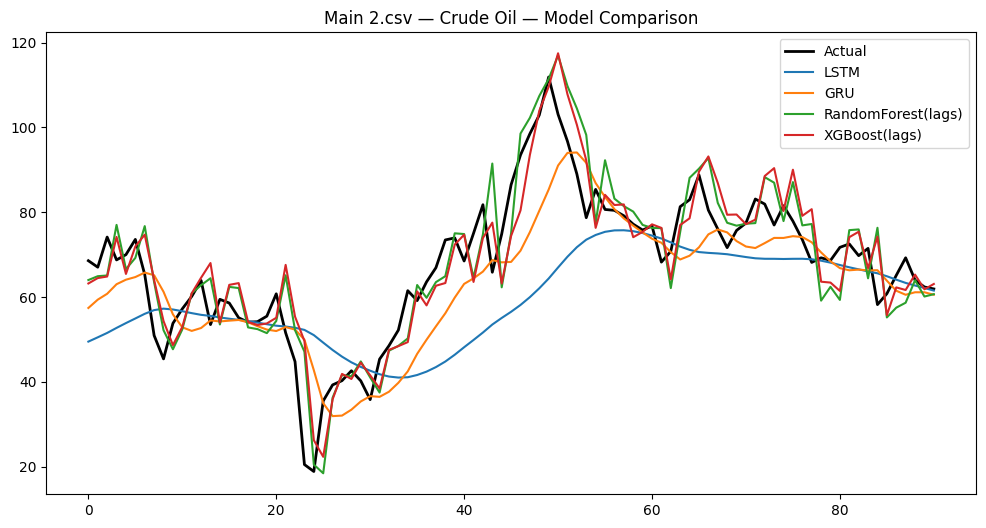


=== Summary (sorted by RMSE) ===
| Model              |    RMSE |     MAE | MAPE   | Directional Acc.   | Notes                                                                 |
|--------------------|---------|---------|--------|--------------------|-----------------------------------------------------------------------|
| Naive (last close) |  6.5544 |  5.0997 | 8.90%  | 0.00%              | Same test window                                                      |
| XGBoost(lags)      |  8.1763 |  6.4789 | 11.31% | 38.89%             | Lagged raw price features; z-scored inputs; 80/20 chronological split |
| RandomForest(lags) |  8.5425 |  6.7495 | 11.37% | 38.89%             | Lagged raw price features; z-scored inputs; 80/20 chronological split |
| GRU(128→64), L=60  | 10.2278 |  7.7021 | 13.35% | 52.22%             | ~87617 params; 80/20 split; scaler fit on train                       |
| LSTM(128→64), L=60 | 15.8167 | 11.4426 | 18.36% | 54.44%             | ~116033 params; 80/20 s

In [ ]:
# dataset2_four_models_compare.py
# Extends your crude-oil LSTM with GRU + RandomForest(lags) + XGBoost(lags) fallback to GradientBoosting(lags)

import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['figure.figsize'] = (12, 6)

# -------------------- Config --------------------
CSV_PATH   = "/content/Main 2.csv"  # change if needed
LOOKBACK   = 60
EPOCHS     = 20
BATCH_SIZE = 32
PATIENCE   = 5
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# -------------------- Metrics helpers --------------------
def compute_regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    yt, yp = y_true[m], y_pred[m]
    rmse = float(np.sqrt(np.mean((yt - yp) ** 2)))
    mae  = float(np.mean(np.abs(yt - yp)))
    denom = np.clip(np.abs(yt), 1e-8, None)
    mape = float(100.0 * np.mean(np.abs((yt - yp) / denom)))
    if yt.size >= 2:
        true_dir = np.sign(yt[1:] - yt[:-1])
        pred_dir = np.sign(yp[1:] - yt[:-1])  # next-step move vs previous true
        da = float(100.0 * np.mean(true_dir == pred_dir))
    else:
        da = np.nan
    return rmse, mae, mape, da  # [attached_file:1]

def print_metrics_table(model_name, y_true, y_pred, notes=""):
    rmse, mae, mape, da = compute_regression_metrics(y_true, y_pred)
    df = pd.DataFrame([{
        "Model": model_name,
        "RMSE": f"{rmse:.4f}",
        "MAE": f"{mae:.4f}",
        "MAPE": f"{mape:.2f}%",
        "Directional Acc.": f"{da:.2f}%" if np.isfinite(da) else "N/A",
        "Notes": notes
    }])
    try:
        import tabulate
        print(tabulate.tabulate(df, headers="keys", tablefmt="github", showindex=False))
    except Exception:
        print(df.to_markdown(index=False))
    return df  # [attached_file:1]

# -------------------- Data loading & preparation --------------------
def load_crude_oil_csv(path):
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]

    date_cols = [c for c in df.columns if 'date' in c]
    if not date_cols:
        raise ValueError("No column looks like a date.")
    df = df.rename(columns={date_cols[0]: 'date'})
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date']).sort_values('date').drop_duplicates(subset=['date']).reset_index(drop=True)

    possible_price_cols = ['close','open','price','value','rate','crude','oil']
    price_col = None
    for c in df.columns:
        if any(k in c for k in possible_price_cols):
            price_col = c
            break
    if price_col is None:
        raise ValueError("No usable price column found.")
    df = df.rename(columns={price_col: 'close'})
    df['close'] = pd.to_numeric(df['close'], errors='coerce').ffill().bfill()
    return df  # [attached_file:1]

def make_xy(dataset, lookback):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)  # [attached_file:1]

# -------------------- Sequence models (LSTM/GRU) --------------------
def build_lstm(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model  # [attached_file:1]

def build_gru(input_shape):
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        GRU(64),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model  # [attached_file:1]

def train_eval_sequence(series_values, lookback, builder, label):
    scaler = MinMaxScaler((0,1))
    scaled = scaler.fit_transform(series_values.reshape(-1,1))

    train_size = int(len(scaled)*0.8)
    train_data = scaled[:train_size]
    test_data  = scaled[train_size - lookback:]

    X_train, y_train = make_xy(train_data, lookback)
    X_test,  y_test  = make_xy(test_data, lookback)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test  = X_test.reshape(X_test.shape[0],  X_test.shape[1],  1)

    es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
    model = builder((lookback,1))
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, validation_split=0.1, callbacks=[es])

    pred_scaled = model.predict(X_test, verbose=0)
    pred = scaler.inverse_transform(pred_scaled).reshape(-1)
    actual = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(-1)

    rmse = sqrt(mean_squared_error(actual, pred))
    return {
        "name": label,
        "actual": actual,
        "pred": pred,
        "rmse": rmse,
        "params": int(sum(l.count_params() for l in model.layers))
    }  # [attached_file:1]

# -------------------- Tabular models on lagged features --------------------
def build_lagged_matrix(series_values, lags=60):
    y = pd.Series(series_values.reshape(-1), name='y')
    df = pd.DataFrame({'y': y})
    for L in range(1, lags+1):
        df[f'lag_{L}'] = df['y'].shift(L)
    df = df.dropna().reset_index(drop=True)
    X = df.drop(columns=['y']).values
    y = df['y'].values
    return X, y  # [attached_file:1]

def train_eval_tabular(series_values, lags=60):
    X_all, y_all = build_lagged_matrix(series_values, lags=lags)
    split = int(0.8 * len(X_all))
    X_train_raw, X_test_raw = X_all[:split], X_all[split:]
    y_train, y_test = y_all[:split], y_all[split:]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw)
    X_test  = scaler.transform(X_test_raw)

    rows = []

    rf = RandomForestRegressor(
        n_estimators=400, max_depth=None, min_samples_leaf=2,
        random_state=RANDOM_SEED, n_jobs=-1
    )
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_test)
    rows.append(("RandomForest(lags)", pred_rf, "Lagged raw price features; z-scored inputs"))  # [attached_file:1]

    if HAS_XGB:
        xgb = XGBRegressor(
            n_estimators=600, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            random_state=RANDOM_SEED, tree_method="hist"
        )
        xgb.fit(X_train, y_train, verbose=False)
        pred_xgb = xgb.predict(X_test)
        rows.append(("XGBoost(lags)", pred_xgb, "Lagged raw price features; z-scored inputs"))  # [attached_file:1]
    else:
        gbr = GradientBoostingRegressor(
            n_estimators=500, learning_rate=0.05, max_depth=3, random_state=RANDOM_SEED
        )
        gbr.fit(X_train, y_train)
        pred_gbr = gbr.predict(X_test)
        rows.append(("GradientBoosting(lags)", pred_gbr, "Lagged raw price features; z-scored inputs"))  # [attached_file:1]

    return y_test, rows  # [attached_file:1]

# -------------------- Baseline --------------------
def naive_last_close_baseline(y_true):
    if len(y_true) < 2:
        return np.array([])
    return np.concatenate([[y_true[0]], y_true[:-1]])  # [attached_file:1]

# -------------------- Main --------------------
def main():
    df = load_crude_oil_csv(CSV_PATH)
    series = df['close'].astype(float).values

    # Sequence models
    res_lstm = train_eval_sequence(series, LOOKBACK, build_lstm, label=f"LSTM(128→64), L={LOOKBACK}")
    res_gru  = train_eval_sequence(series, LOOKBACK, build_gru,  label=f"GRU(128→64), L={LOOKBACK}")

    # Tabular models
    y_test_tab, tab_models = train_eval_tabular(series, lags=LOOKBACK)

    # Align comparable window (tail-align to shortest test)
    n_seq = len(res_lstm["actual"])
    n_tab = len(y_test_tab)
    n = min(n_seq, n_tab)

    def tail(v): return v[-n:]
    actual_common = tail(res_lstm["actual"])

    # Plot
    fig, ax = plt.subplots()
    ax.plot(actual_common, label='Actual', color='black', linewidth=2)

    rows = []

    # LSTM metrics
    lstm_pred_common = tail(res_lstm["pred"])
    rows.append(print_metrics_table(res_lstm["name"], actual_common, lstm_pred_common,
                                    notes=f"~{res_lstm['params']} params; 80/20 split; scaler fit on train"))  # [attached_file:1]
    ax.plot(lstm_pred_common, label='LSTM')

    # GRU metrics
    gru_pred_common = tail(res_gru["pred"])
    rows.append(print_metrics_table(res_gru["name"], actual_common, gru_pred_common,
                                    notes=f"~{res_gru['params']} params; 80/20 split; scaler fit on train"))  # [attached_file:1]
    ax.plot(gru_pred_common, label='GRU')

    # Tabular models
    for name, pred_tab, note in tab_models:
        pred_common = tail(pred_tab)
        rows.append(print_metrics_table(name, actual_common, pred_common,
                                        notes=f"{note}; 80/20 chronological split"))  # [attached_file:1]
        ax.plot(pred_common, label=name)

    # Naive baseline on same window
    naive_pred = naive_last_close_baseline(actual_common)
    rows.append(print_metrics_table("Naive (last close)", actual_common, naive_pred,
                                    notes="Same test window"))  # [attached_file:1]

    ax.set_title(f"{os.path.basename(CSV_PATH)} — Crude Oil — Model Comparison")
    ax.legend()
    plt.show()

    # Summary table sorted by RMSE
    summary = pd.concat(rows, ignore_index=True)
    summary2 = summary.copy()
    summary2["RMSE_val"] = summary2["RMSE"].astype(float)
    summary_sorted = summary2.sort_values("RMSE_val").drop(columns=["RMSE_val"])
    try:
        import tabulate
        print("\n=== Summary (sorted by RMSE) ===")
        print(tabulate.tabulate(summary_sorted, headers="keys", tablefmt="github", showindex=False))
    except Exception:
        print(summary_sorted.to_markdown(index=False))

    best_row = summary_sorted.iloc[0]
    print(f"\nBest by RMSE on this dataset: {best_row['Model']} (RMSE={best_row['RMSE']})")
    return summary_sorted  # [attached_file:1]

if __name__ == "__main__":
    main()
